In [1]:
import pandas as pd
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv('data/2_state_data.csv', index_col=0)

In [2]:
df.head()

,State,Quantity,Acquisition Value,numStations,exp per station,deaths,pctBodyCam,pctfleeing,pctMHSymptoms,pctDeathsBlack,...,pctDeathsAsian,pctDeathsOther,pctPopWhite,pctPopBlack,pctPopHisp,pctPopAsian,pctPopOther,pctPopNative,Population,deaths_per_100k
0,AK,17782,1644529.46,209,7868.562010,39.0,10.26,48.72,15.38,7.692308,...,5.128205,10.256410,60.0,3.0,7.0,6.0,7.0,17.0,732517.0,5.324109
1,AL,13116,40407156.02,1646,24548.697461,104.0,13.46,36.54,25.00,28.846154,...,0.000000,9.615385,66.0,26.0,4.0,1.0,2.0,1.0,4845319.8,2.146401
2,AR,9595,7867417.67,868,9063.845242,81.0,4.94,32.10,16.05,30.864198,...,1.234568,13.580247,72.0,15.0,8.0,2.0,3.0,2.0,2973843.5,2.723748
3,AZ,8143,6990431.91,642,10888.523224,253.0,10.28,35.18,18.58,6.719368,...,0.000000,13.043478,54.0,4.0,32.0,3.0,2.0,5.0,6804946.7,3.717884
4,CA,38522,46904224.48,1843,25449.931894,793.0,14.12,36.32,22.70,15.006305,...,3.656999,12.610340,37.0,5.0,39.0,15.0,3.0,2.0,38618190.0,2.053436


In [3]:
df.dtypes

State                 object
Quantity               int64
Acquisition Value    float64
numStations            int64
exp per station      float64
deaths               float64
pctBodyCam           float64
pctfleeing           float64
pctMHSymptoms        float64
pctDeathsBlack       float64
pctDeathsWhite       float64
pctDeathsHispanic    float64
pctDeathsNative      float64
pctDeathsAsian       float64
pctDeathsOther       float64
pctPopWhite          float64
pctPopBlack          float64
pctPopHisp           float64
pctPopAsian          float64
pctPopOther          float64
pctPopNative         float64
Population           float64
deaths_per_100k      float64
dtype: object

In [4]:
dfd = pd.get_dummies(df['State'])

for series in dfd:
    dfd[series] = dfd[series].astype(float)
dfd = pd.concat([df.drop(['State'],axis=1),dfd],axis=1)


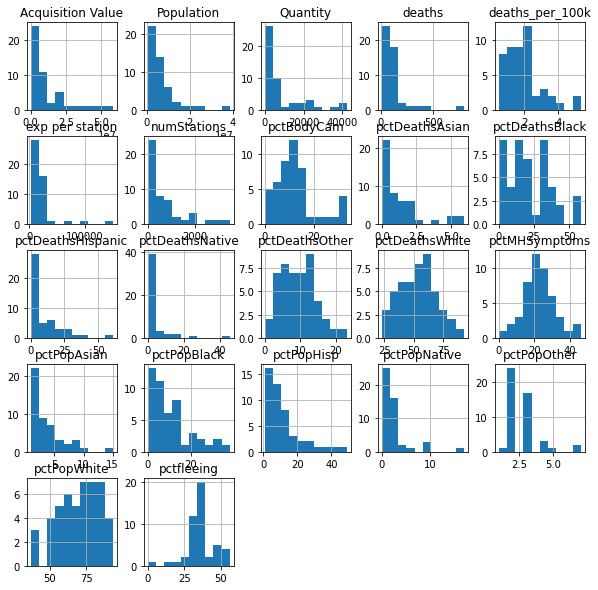

In [5]:
df.hist(figsize=(10,10))
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
X = dfd.drop(columns=['deaths_per_100k','deaths']).values
y = dfd.deaths_per_100k.values

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [9]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Modeling

## Model 1 - KNN

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score

In [11]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)

In [12]:
r2_score(y_test,y_pred)

0.123653841365995

In [13]:
param_grid = {'n_neighbors':np.arange(1,10),
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knr_cv = GridSearchCV(knr, param_grid=param_grid, cv=5)
knr_cv.fit(X_train, y_train)
y_pred2 = knr_cv.predict(X_test)

knr_cv.best_params_

{'algorithm': 'auto', 'n_neighbors': 5}

In [14]:
knr2 = KNeighborsRegressor(n_neighbors=6)
knr2.fit(X_train, y_train)
y_pred3 = knr2.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error, explained_variance_score
print("R2 Score: " + str(r2_score(y_test, y_pred3)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred3)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred3)))

R2 Score: 0.0889977860831791
MSE Score: 0.6198950748971803
Explained Variance Score: 0.1439075757273981


Text(0, 0.5, 'Y_Pred Values')

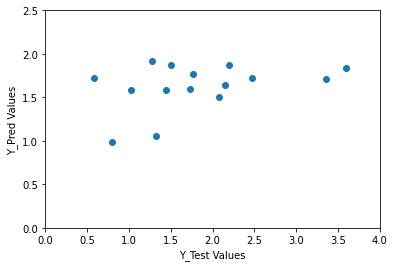

In [16]:
plt.scatter(x=y_test, y=y_pred3)
plt.xlim(0,4)
plt.ylim(0,2.5)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 2

In [17]:
import xgboost as xgb
from xgboost import XGBRegressor

xgbreg = XGBRegressor(random_state=42,silent=True)
xgbreg.fit(X_train,y_train)
y_pred4 = xgbreg.predict(X_test)


In [18]:
print("R2 Score: " + str(r2_score(y_test, y_pred4)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred4)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred4)))

R2 Score: 0.06434180380040333
MSE Score: 0.6366723359733432
Explained Variance Score: 0.06490052722056083


In [19]:
param_grid = ({'n_estimators': np.arange(1,15),
               'max_depth': np.arange(1,15),
               'learning_rate':[0.1,0.3,0.5,0.7]})
xgbreg_cv = GridSearchCV(xgbreg, param_grid=param_grid, cv=5)
xgbreg_cv.fit(X_train, y_train)
y_pred5 = xgbreg_cv.predict(X_test)

In [20]:
xgbreg_cv.best_params_

{'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 11}

In [21]:
xgbreg2 = XGBRegressor(n_estimators=11, max_depth=2, learning_rate=0.7, booster='gbtree', random_state=42,silent=True)
xgbreg2.fit(X_train,y_train)
y_pred5 = xgbreg2.predict(X_test)

In [22]:
print("R2 Score: " + str(r2_score(y_test, y_pred5)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred5)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred5)))

#odd, results are not as strong as before using gridsearch.

R2 Score: 0.15084235323091155
MSE Score: 0.5778126935391833
Explained Variance Score: 0.15435678144594833


In [23]:
features = pd.DataFrame(xgbreg.feature_importances_, index=dfd.columns[1:69])
features[features[0]>0].sort_values(by=0, ascending=False)

,0
pctPopNative,0.530638
pctPopAsian,0.152446
exp per station,0.053127
pctDeathsNative,0.042837
pctDeathsBlack,0.033530
pctDeathsOther,0.033360
pctDeathsWhite,0.031251
Population,0.028683
pctPopBlack,0.021564
Acquisition Value,0.019192


Text(0, 0.5, 'Y_Pred Values')

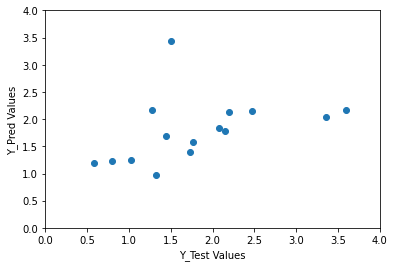

In [28]:
plt.scatter(x=y_test, y=y_pred4)
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 3

In [29]:
from sklearn.cluster import KMeans

In [39]:
kmean = KMeans(random_state=123)
kmean.fit(X_train,y_train)
y_pred6 = kmean.predict(X_test)

In [40]:
print("R2 Score: " + str(r2_score(y_test, y_pred6)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred6)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred6)))
kmean.get_params

R2 Score: -8.685837210621637
MSE Score: 6.590766401439734
Explained Variance Score: -5.610837426365136


<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)>

In [53]:
param_grid = {'n_clusters':np.arange(1,10),
              'n_init':np.arange(1,20)
             }
kmean_cv = GridSearchCV(kmean, param_grid=param_grid, cv=5)
kmean_cv.fit(X_train, y_train)
y_pred3 = kmean_cv.predict(X_test)

kmean_cv.best_params_

{'n_clusters': 2, 'n_init': 13}

In [54]:
kmean2 = KMeans(n_clusters=2, n_init=13,random_state=123)
kmean2.fit(X_train,y_train)
y_pred7 = kmean2.predict(X_test)

In [55]:
print("R2 Score: " + str(r2_score(y_test, y_pred7)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred7)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred7)))

R2 Score: -2.3324106824141166
MSE Score: 2.2675520849523156
Explained Variance Score: -0.14449137938746115
